<center><h1><b>Análisis de Sentimientos de Twitter</b></h1></center>

<center><h1><b>Preliminares</b></h1></center>

## **1- Descripción del problema**

Se nos presenta un problema clásico de análisis de texto: Extraer la polaridad de sentimientos asociados a un texto.

Como objetivo general nos piden alcanzar el mejor desempeño para clasificar si los tweets tienen una polaridad positiva o negativa en cuanto a la emoción que expresa. Además, nos piden entregar los dos mejores modelos serializados para la evaluación.

El desempeño se evaluará en un **conjunto de datos al cúal no tendremos acceso.**

Para realizar el trabajo, nos entregan un conjunto de datos con el nombre de **training_tweets.csv**. Los atributos disponibles en el conjunto de datos son:

* sentiment: Sentimiento asociado al tweet escrito por el usuario. 

* content: Tweet escrito por el usuario.

Nuestra variable objetivo será **sentiment** ya que nos piden clasificar si el tweet tiene una polaridad **negativa** o **positiva**. Como nos están pidiendo realizar una clasificación binaria, trataremos al problema con **Modelos de Clasificación**. Más adelante declararemos una grilla de búsqueda tentativa con los respectivos modelos.

### **1.1 Métricas y división de muestras**

#### **Métricas**

Para medir el **desempeño de los Modelos de Clasificación** y obtener los dos mejores, nos guíaremos por el Accuracy de Validación. El proceso será el siguiente:

* Realizamos una búsqueda de grilla con GridSearchCV, con un Kfold de 5.

* Con el best estimator de cada modelo predecimos en conjunto de validación que nunca entró en la Grilla de Búsqueda.

* Con los datos predichos, obtenemos un Accuracy de Validación a través de Accuracy Score.

> Accuracy: Medimos exactitud de nuestro modelos. Casos predichos del total de observaciones.

#### **División de muestras**

Como estrategia de división de muestras, dividiremos el conjunto de datos con el método train_test_split de la librería sklearn.model_selection de la siguiente forma:

* **X_train:** Conjunto de entrenamiento de la variable atributo **content**.

* **X_test:** Conjunto de validación de la variable atributo **content**.

* **y_train:** Conjunto de entrenamiendo de la variable objetivo **sentiment**.

* **y_test:** Conjunto de respuestas correctas de la variable X_test.

### **1.1 Consideraciones**

Debido a que estamos utilizando la librería NLKT para el preprocesamiento, especificamente lemantización, se requiere de las siguientes descargar para ejecutar los modelos:

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

---

<center><h1><b>Aspectos Computacionales</b></h1></center>

Sección donde se entregará a detalle las librerías a utilizar, preprocesamiento de variables y grilla tentativa de modelos con sus hiperparámetros a buscar.

## **2.1 Librerías**

Las librerías a utilizar serán las siguientes:

#### **Ingesta de datos**

In [2]:
import pandas as pd

#### **Preprocesamiento**

In [3]:
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from functions import random_neutral, random_neutral_string, recod_emotions, countplot_sns, wordcloud_graph, plot_freq_words,TweetsPreprocessing, gridsearch_train
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#### **Visualización**

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10, 6)

#### **Modelación**

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#### **Evaluación**

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

**Serialización**

In [ ]:
from joblib import dump, load

## **2.2 Detalles del proceso de recodificación e ingeniería de atributos**

En esta sección veremos como se realizará el preprocesamiento de la variable atributo **content** y la variable objetivo **sentiment** junto con su solución. La recodificación e ingeniería de atributos lo dividiremos en dos grandes grupos:

* **Exploración:** Preprocesamiento llevado a cabo para fines exploratorios de la variable objetivo y atributo.

* **Modelación:** Preprocesamiento llevado a cabo para fines de modelación de la variable objetivo y atributo.

#### **2.2.1 Preprocesamiento para Exploración de variable objetivo sentiment.**

Para tratar la variable objetivo nos entregan la siguiente lista con las emociones originales junto con su respectiva recodificación:

| Original | Recodificación |
| ---      | ---            |
| worry    | Negativa       |
| happiness| Positiva       |
| sadness  | Negativa       |
| love     | Positiva       |
| surprise | Positiva       |
| fun      | Positiva       |
| relief   | Positiva       |
| hate     | Negativa       |
| empty    | Negativa       |
| enthusiasm| Positiva      |
| boredom  | Negativa       |
| anger    | Negativa       |

También nos señalan que un tweet asignado como **neutral** debe ser recodificado de manera aleatoria como positivo o negativo.

Para solucionar esta recodificación, contamos con una función llamada recod_emotions en la cúal se pasas por parametros un data frame con las columnas a recodificar, una lista de las variables que deberían pertenecer a la emoción binaria(Positiva o Negativa) y finalmente con que emoción se cátaloga.

**Ejemplo:**
``` py
positive_list = ['happiness','love','surprise','fun','relief','enthusiasm']
df['sentiment'] = recod_emotions(df, 'sentiment', positive_list, 'positiva')

```
Y para solucionar la randomización de **neutral** contamos con una función llamada random_neutral_string, en la cúal aplicamos la función directamente en la variable objetivo. Esta función se encarga de encontrar las emociones neutrales y recodificarla de forma aleatoria como 'positiva' o 'negativa'. Para que esto funcione debe ser aplicado fila por fila, ya que si se realiza de forma vectorizada, las clases quedarán desbalanceadas.

**Ejemplo:**
``` py
df['sentiment'] = df['sentiment'].apply(func=random_neutral_string)
```

#### **2.2.2 Preprocesamiento para Exploración de variable atributo content.**

Para realizar una correcta exploración de la variable atributo content, debemos pre procesar los tweets realizando una limpieza de palabras, en la cúal aplicaremos un transform con la clase TweetsPreprocessing importada desde el archivo functions.py. Lo que realiza esta clase en los tweets es lo siguiente:

* Elimina hipervinculos https.

* Aplica lower a todas las palabras para eliminar mayusculas.

* Elimina usuarios @. Ejemplo: @user.

* Elimina carácteres especiales.

* Elimina palabras cortas.

* Elimina palabras más comunes.

* Realiza una lemantización de las palabras, dejando la palabra con un tronco léxico común.

#### **2.2.3 Preprocesamiento variable objetivo sentiment para Modelación.**

Para que la variable objetivo sentiment sea utilizada para modelación y entrenamiento, se recodificará la emoción positiva como 1 y la emoción negativa como 0. Esto se aplicará directamente en la variable objetivo **sentiment** de la siguiente forma:

**Ejemplo**
```py
df['sentiment'] = np.where(df['sentiment']=='positiva',1,df['sentiment'])
```

#### **2.2.4 Detalle preprocesamiento variable atributo content para Modelación.**

Para utilizar la variable content en la modelación y entrenamiento de modelos, se utilizará la clase TweetPreprocessing dentro del Pipeline para realizar una limpieza directa de palabras en la variable content y posterior a esto se utilizará un CountVectorizer, el cúal transforma la variable en una matriz.

**Ejemplo**

```py
pipe = Pipeline([
                ('tweet_pre', TweetsPreprocessing()), # Utilizamos la clase para limpiar los tweets
                ('cv', CountVectorizer(max_df=0.90, min_df=2, max_features=100, stop_words=stop_words)), # Utilizamos CountVectorizer para que se transforme en una matriz.
                ('model', LogisticRegression())
            ])
```

## **2.3 Grilla de modelos e Hiperparámetros a buscar.**

Los modelos y la grilla de hiperparámetros a buscar es la siguiente:

In [7]:
rand_state = 1180

dict_models = {
    'Logistic_Regression': (LogisticRegression(random_state=rand_state), {
        'model__C': [.1, 1],
        'model__max_iter': [100, 5000]
    }),
    'svc': (SVC(random_state=rand_state), {
        'model__C':  np.linspace(0.01, 2, 30),
        'model__max_iter': [10, 500],
        'model__gamma': ['auto', 'scale']
    }),
    'Decision_Tree_Classifier': (DecisionTreeClassifier(random_state=rand_state, min_impurity_decrease=.5), {
        'model__criterion':['gini', 'entropy', 'log_loss'],
        'model__max_depth':[1, 5, 10], 
        'model__max_features':['auto', 'sqrt', 'log2'],
        'model__min_samples_split':[0.01, 0.7]
    }),
    'AdaBoostClassifier': (AdaBoostClassifier(base_estimator=LogisticRegression(C=1), random_state=123), {
        'model__n_estimators':[10, 50]
    }),
    'AdaBoostClassifier_dt': (AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), random_state=123, learning_rate=1), {
        'model__n_estimators':[10, 20]
    }),
    'Random_Forest':(RandomForestClassifier(random_state=rand_state, n_jobs=-1), {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth':[1, 5, 8, 10],
        'model__max_features': ['sqrt', 'log2', None]
    }),
    'Gradient_Boosting_Classifier':(GradientBoostingClassifier(random_state=rand_state), {
        'model__max_features': ['auto','sqrt','log2'],
        'model__n_estimators':[15, 30],
        'model__max_depth':[1, 4],
        'model__learning_rate':[0.5, 1]
    }),
    'Multinomial_Naive_Bayes':(MultinomialNB(), {
        'model__alpha': [0.1,1.0]
    }),
    'Bernoulli_Naive_Bayes':(BernoulliNB(fit_prior=False), {
        'model__alpha': [0.01, 0.05]    
    }),
    'Ridge_Classifier':(RidgeClassifier(random_state = 123), {
        'model__alpha': [0.1,1.0],
        'model__max_iter': [10, 500]
    })
}

---

<center><h1><b>Análisis Exploratorio y Preprocesamiento</b></h1></center>

En esta sección comenzamos el análisis exploratorio y aplicamos el preprocesamiento de las variables declarado anteriormente.

In [8]:
df = pd.read_csv('training_tweets.csv').drop(columns='Unnamed: 0') # Ingestamos la data en variable df

## **3.1 Explorando variable objetivo**

#### **Recodificación de emociones**

In [9]:
negative_list = ['worry','sadness','hate','empty','boredom','anger']
positive_list = ['happiness','love','surprise','fun','relief','enthusiasm']

df['sentiment'] = recod_emotions(df, 'sentiment', positive_list, 'positiva')
df['sentiment'] = recod_emotions(df, 'sentiment', negative_list, 'negativa')

#### **Exploración Vector objetivo antes de randomizar neutral**

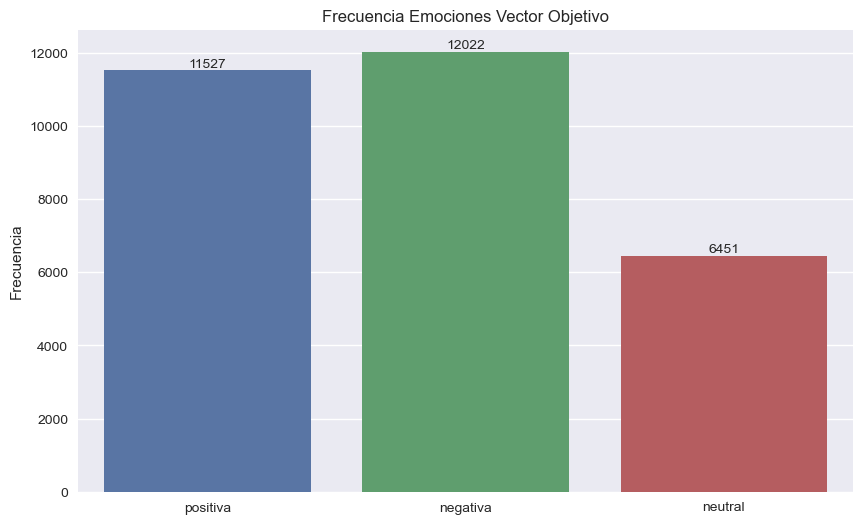

In [10]:
countplot_sns(df, 'sentiment', 'Frecuencia Emociones Vector Objetivo')

**Comentarios:**

* Se observa un cierto balance entre la Clase Positiva y Negativa. Esperamos que se mantenga de esta manera al momento de catalogar la Clase neutral de forma aleatoria entre Positiva y Negativa.

#### **Randomizar emoción Neutral**

In [11]:
np.random.seed(5)

df['sentiment'] = df['sentiment'].apply(func=random_neutral_string)

In [12]:
df['sentiment'].value_counts()

negativa    15252
positiva    14748
Name: sentiment, dtype: int64

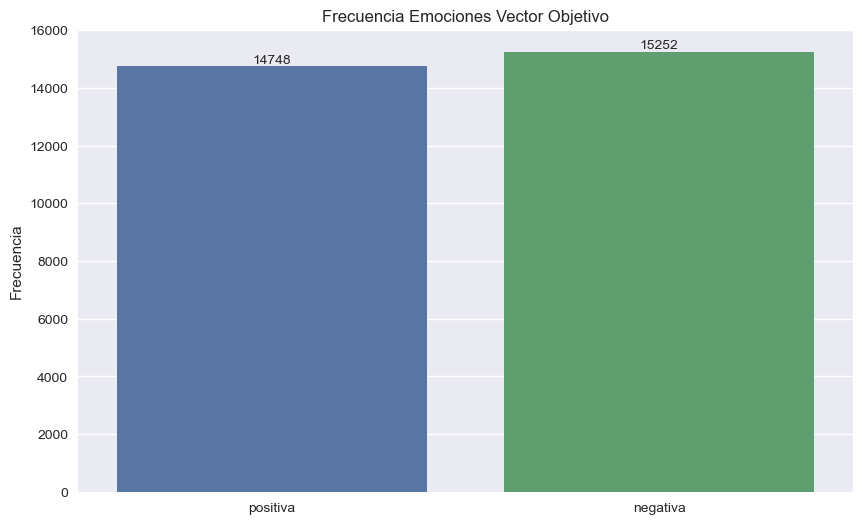

In [13]:
countplot_sns(df, 'sentiment', 'Frecuencia Emociones Vector Objetivo')

**Comentarios:**

* Observamos que la función cumple con la aleatoriedad, clasificando las observaciones neutrales entre Positiva y Negativa de manera Random, dejandolas relativamente balanceadas.

## **3.1 Explorando variable atributo content**

Para explorar la variable atributo content y observar las palabras más frecuentes según su emoción, utilizamos la clase TweetsPreprocessing aplicandola en la variable content, pero creando una nueva columna, para que posteriormente al modelar, el preprocesamiento de este se llevará a cabo directamente en el Pipeline.

#### **Preprocesamiento de variable atributo**

In [13]:
df['clean_tweet'] = TweetsPreprocessing().transform(df['content'])

### **3.1.1 Palabras negativas**

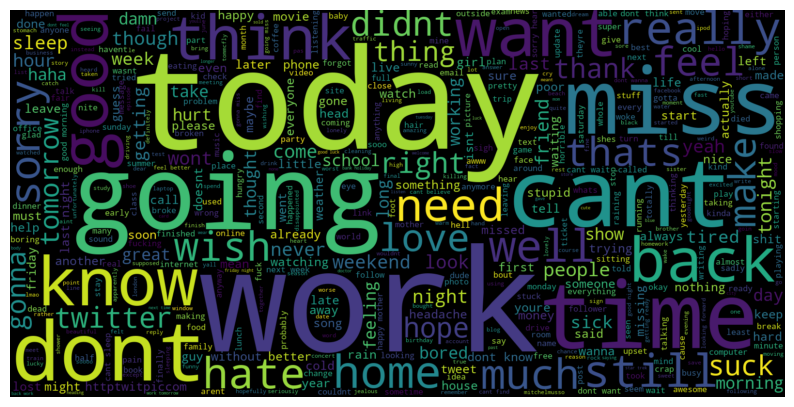

In [14]:
wordcloud_graph(df, 'clean_tweet', 'sentiment', 'negativa')

**Comentarios:**

A primera vista el gráfico nos entrega palabras destacables como "today","work,"time","sorry". A la misma vez, observamos palabras como good, que a nuetro parecer es curioso que aparezca dentro de las más frecuentes cuando se asocia a sentimientos negativos.

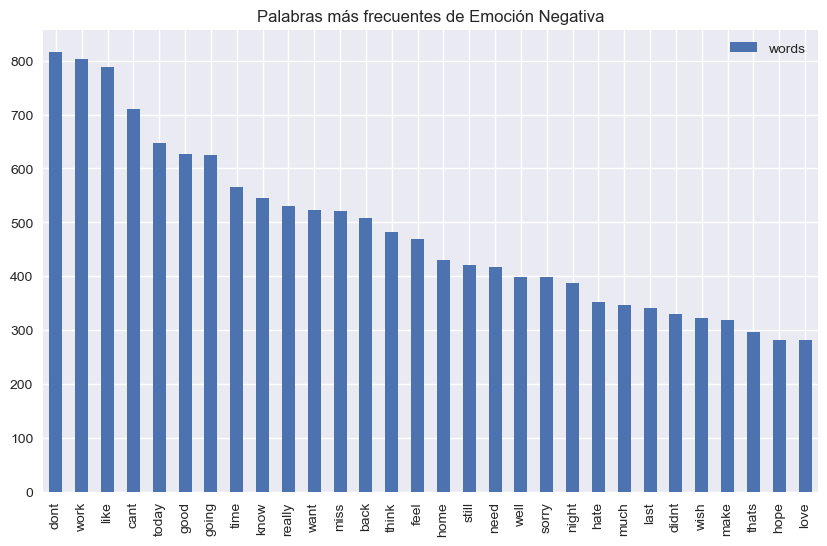

In [15]:
df_negativa = df[df['sentiment']=='negativa']
plot_freq_words(df_negativa, 'clean_tweet', 'Palabras más frecuentes de Emoción Negativa', 30)

**Comentarios:**

* Como curiosidad nos fijamos que las palabras pueden tener un único contexto(por ejemplo hate que solo tiene contexto negativo) mientras que hay otras palabras que pueden tener tanto contexto negativo como positivo(por ejemplo love).

* Si bien "dont" no es una palabra única, ya que se compone por "do not", la podemos a asociar a un aspecto negativo dado su significado al igual que "cant"

* Pareciera ser que las personas al hablar de trabajo("work") conlleva una emoción negativa.

* Las palabras más destacables que podrían denotar un aspecto negativo son "hate", "sorry".

* Si bien "love" aparece dentro de una frecuencia alta, esta se encuentra de las últimas, al contrario que en las emociones positivas, la cuál aparece de las primeras.

### **3.1.1 Palabras positivas**

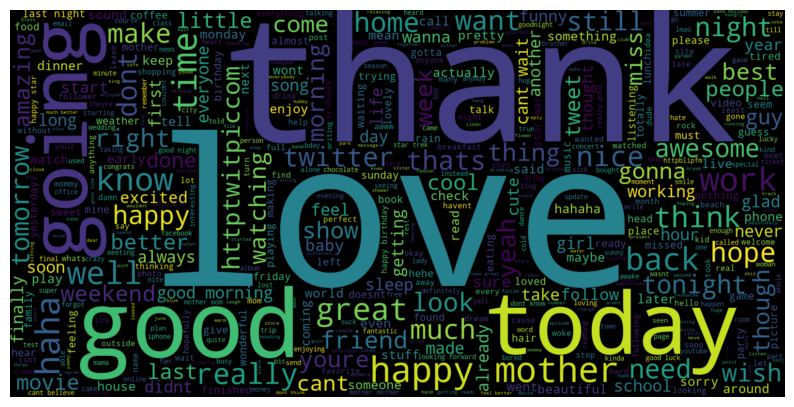

In [16]:
wordcloud_graph(df, 'clean_tweet', 'sentiment', 'positiva')

**Comentarios:**

A diferencia del wordcloud de las emociones negativas, aquí se destacan más las palabras que a primera vista uno puede relacionar como emociones positivas, por ejemplo: Love, good, thank, happy, mother. Si bien son palabras que aparecen en el wordcloud de emociones negativas, aparecen muy pequeñas a diferencia de este.

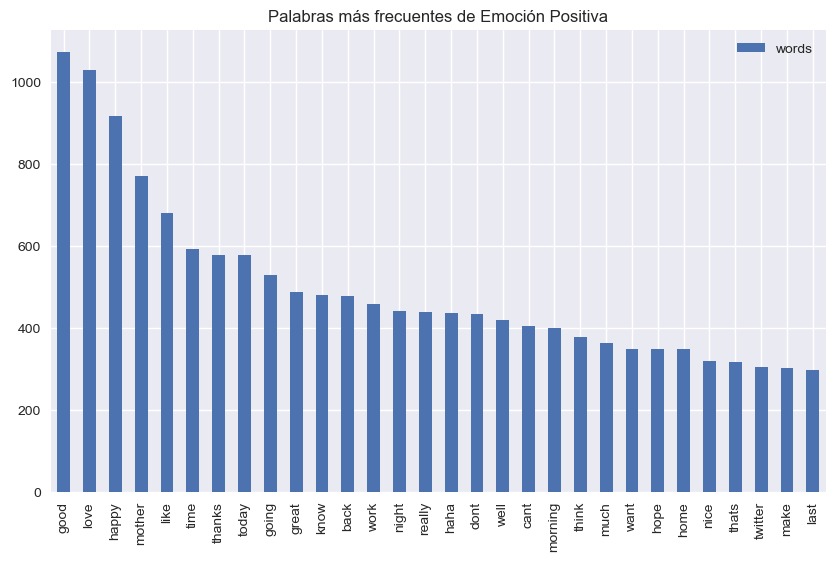

In [17]:
df_positiva = df[df['sentiment']=='positiva']
plot_freq_words(df_positiva, 'clean_tweet', 'Palabras más frecuentes de Emoción Positiva', 30)

**Comentarios:**

Podemos destacar las siguientes diferencias con las palabras más frecuentes de las emociones negativas:

* Love aparece en las frecuencias más altas.

* Work tiene menos frecuencia que en las emociones negativas.

* Palabras como "good", "happy" las podemos asociar fuertemente a emociones positivas solo por su significado.

* Podemos apreciar un "haha" dentro de las frecuencias de emociones positivas, el cuál se caracterisa por ser una risa.

---

<center><h1><b>Modelamiento</b></h1></center>

#### **4.1 Preprocesamiento variable atributo**

Como declaramos anteriormente, preprocesamos la variable atributo sentiment de forma manual, dejando como Clase 1 a la emoción positiva y como Clase 0 a la emoción negativa.

In [18]:
df['sentiment'] = np.where(df['sentiment']=='positiva',1,df['sentiment'])
df['sentiment'] = np.where(df['sentiment']=='negativa',0,df['sentiment'])

df['sentiment'] = df['sentiment'].astype('int64')

#### **Comprobamos como queda la variable luego de la recodificación**

In [19]:
df['sentiment'].value_counts()

0    15252
1    14748
Name: sentiment, dtype: int64

#### **4.2 División de muestras**

In [20]:
X = df['content']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=125)

#### **4.3 Búsqueda de mejores hiperparámetros**

In [22]:
df_grid, dict_modelos = gridsearch_train(dict_models, X_train, X_test, y_train, y_test)

In [27]:
df_grid.sort_values(by='acc_validacion', ascending=False)

,best_score,best_params,acc_validacion
Logistic_Regression,0.6239,"{'model__C': 1, 'model__max_iter': 100}",0.613535
Multinomial_Naive_Bayes,0.6207,{'model__alpha': 0.1},0.613333
Ridge_Classifier,0.6232,"{'model__alpha': 0.1, 'model__max_iter': 10}",0.612020
Bernoulli_Naive_Bayes,0.6222,{'model__alpha': 0.01},0.611111
AdaBoostClassifier_dt,0.6174,{'model__n_estimators': 20},0.608586
Random_Forest,0.6168,"{'model__max_depth': 8, 'model__max_features':...",0.606465
Gradient_Boosting_Classifier,0.6198,"{'model__learning_rate': 1, 'model__max_depth'...",0.606162
AdaBoostClassifier,0.6120,{'model__n_estimators': 50},0.602828
svc,0.5119,"{'model__C': 0.01, 'model__gamma': 'auto', 'mo...",0.517677
Decision_Tree_Classifier,0.5098,"{'model__criterion': 'gini', 'model__max_depth...",0.505556


**Comentarios:**

Escogeremos los dos mejores modelos por el accuracy de validación, los cuales serían:

* Logistic_Regression con un Acc de validación de 0.613535

* Multinomial_Naive_Bayes con un Acc de validación de 0.613333.

Observaremos si hubo overfitting en la grilla de búsqueda:

In [49]:
# Extraemos el modelo del diccionario.

model_lr = dict_modelos['Logistic_Regression']

# Transformamos cv_result en Dataframe
cv_result_lr = pd.DataFrame(model_lr.cv_results_)

# Obtenemos mean_train_score y mean_test_score del mejor modelo.
cv_result_lr.iloc[2][['mean_train_score','mean_test_score']]

mean_train_score    0.630634
mean_test_score     0.623881
Name: 2, dtype: object

Observamos que el modelo lr se encuentra dentro de lo óptimo. Ahora verificamos el Multinomial NB:

In [46]:
# Extraemos el modelo del diccionario.
model_mnb = dict_modelos['Multinomial_Naive_Bayes']

# Transformamos cv_result en Dataframe
cv_result_mnb = pd.DataFrame(model_mnb.cv_results_)

# Obtenemos mean_train_score y mean_test_score del mejor modelo.
cv_result_mnb.iloc[0][['mean_train_score','mean_test_score']]

mean_train_score    0.625846
mean_test_score     0.620746
Name: 0, dtype: object

Al igual que el modelo Lr, Multinomial se encuentra dentro de lo óptimo, sin señales de Overfitting. Por lo tanto, procederemos a la serialización de los modelos, escogiendo a estos últimos como los mejores.

<center><h1><b>Serialización</b></h1></center>


In [50]:
import pickle

# Exportar
dump(model_lr.best_estimator_, 'modelo-1.sav')
dump(model_mnb.best_estimator_, 'modelo-2.sav')